In [ ]:
# !source ../venv/bin/activate && python3 -m pip install -r ../requirements/requirements-viz.txt
# !source ../venv/bin/activate && jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyterlab-plotly
import os

import branca.colormap as cm
import folium
import matplotlib
import numpy as np
import plotly.express as px
from folium.features import GeoJsonTooltip
from plotly.offline import iplot

PLOT_FOLDER = os.path.join(os.getcwd(), "indices/")
output_filetypes = ["png"]
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Fiscal health with japandata.indices

In [1]:
from japandata.indices import city, pref, prefmean

In [2]:
# Fiscal indices for the prefectural governments
pref.head()

prefecture  regular-expense-rate  debt-service-rate  debt-restriction-rate  \
0        北海道                  99.9               19.8                   11.7   
1        青森県                  95.2               14.2                   12.3   
2        岩手県                  93.0               13.7                   11.0   
3        宮城県                  94.4               16.8                   13.2   
4        秋田県                  92.7               16.3                   14.4   

   fiscal-strength-index  laspeyres  year  future-burden-rate  
0                0.36251       90.6  2005                 NaN  
1                0.27396       98.2  2005                 NaN  
2                0.27297      100.2  2005                 NaN  
3                0.48082      101.9  2005                 NaN  
4                0.25155      100.1  2005                 NaN

In [3]:
# Fiscal indices for city governments
# Warning: Some columns measure different things for the 23 special wards of Tokyo than for other municipalities.
city.head()

prefecture city  regular-expense-rate  debt-service-rate  \
0        北海道  札幌市                  96.5               14.0   
1        北海道  函館市                  88.9               16.2   
2        北海道  小樽市                  99.1               19.2   
3        北海道  旭川市                  89.9               17.1   
4        北海道  室蘭市                  87.4               12.1   

   debt-restriction-rate  fiscal-strength-index  laspeyres  year   code  \
0                   14.8                   0.67       98.6  2005  01100   
1                   11.3                   0.46       97.1  2005  01202   
2                   15.9                   0.47       89.5  2005  01203   
3                   12.9                   0.51       95.5  2005  01204   
4                    9.5                   0.60       96.2  2005  01205   

   future-burden-rate  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN

In [4]:
# Mean fiscal indices for cities in each prefecture
# Warning: Some columns are weighted means, some are not
prefmean.head()

prefecture  regular-expense-rate  debt-service-rate  debt-restriction-rate  \
0        北海道                  91.8               16.4                   13.0   
1        青森県                  91.5               17.5                   12.3   
2        岩手県                  89.7               17.1                   11.8   
3        宮城県                  92.8               17.0                   13.4   
4        秋田県                  92.2               16.2                   11.5   

   fiscal-strength-index  year  future-burden-rate  
0                   0.27  2005                 NaN  
1                   0.33  2005                 NaN  
2                   0.33  2005                 NaN  
3                   0.53  2005                 NaN  
4                   0.31  2005                 NaN

## Use Plotly to explore this data interactively

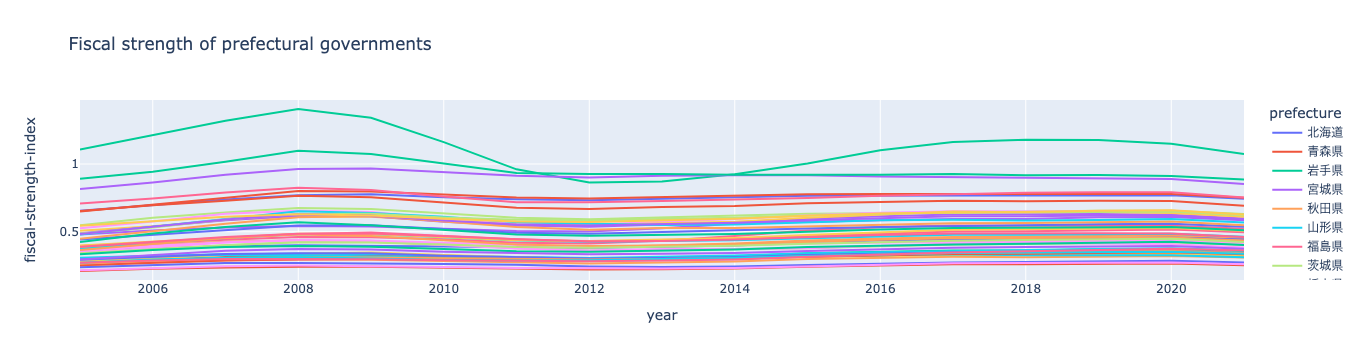

In [7]:
fig = px.line(
    pref,
    x="year",
    y="fiscal-strength-index",
    color="prefecture",
    hover_data=["prefecture"],
    title="Fiscal strength of prefectural governments",
)
fig.write_html(PLOT_FOLDER + "strength_vs_time.html")
iplot(fig)

# Now combine this data with japandata.map

In [8]:
from japandata.maps import add_df_to_map

year = 2021
pref = pref.loc[pref["year"] == year]
city = city.loc[city["year"] == year]


pref_map = add_df_to_map(
    pref, date=year, scale="jp_pref", quality="stylized", clean=True
)

city_map = add_df_to_map(
    city, date=year, scale="jp_city_dc", quality="stylized", clean=True
)

/Users/sam/Projects/civic/japandata/venv/lib/python3.10/site-packages/topojson/core/dedup.py:107: RuntimeWarning:

invalid value encountered in cast



0 failures


/Users/sam/Projects/civic/japandata/venv/lib/python3.10/site-packages/topojson/core/dedup.py:107: RuntimeWarning:

invalid value encountered in cast



0 failures


In [9]:
######################
### Map Styling ######
######################

unhighlighted_style = {
    "color": "black",
    "weight": 1,
    "fillOpacity": 1,
}

highlighted_style = unhighlighted_style | {"weight": 4}

tooltipstyle = """
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """


def fillColor(colormap, feature):
    try:
        return colormap(feature["properties"]["_dummy"])
    except (ValueError, KeyError, TypeError):
        return "black"


map_style = {
    "zoom_start": 5,
    "tiles": "None",
    "attr": " ",
}

In [10]:
datacolumn = "fiscal-strength-index"
datacolumnalias = "Fiscal Strength Index"
scalingfactor = 1
df = city_map.copy()


df["_dummy"] = df[datacolumn] / scalingfactor

rgbacolors = matplotlib.colormaps["coolwarm"](np.linspace(0, 1, 11))
colormap = cm.LinearColormap(
    [matplotlib.colors.to_hex(color) for color in rgbacolors], vmin=0.0, vmax=1.0
)

In [11]:
m = folium.Map(**map_style | {"location": [35.67, 139]})

tooltip = GeoJsonTooltip(
    fields=["prefecture", "city", "_dummy"],
    aliases=["Prefecture:", "City:", datacolumnalias + ":"],
    localize=True,
    sticky=False,
    labels=True,
    style=tooltipstyle,
    max_width=800,
)

folium.GeoJson(
    df,
    name="_dummy",
    style_function=lambda feature: {"fillColor": fillColor(colormap, feature)}
    | unhighlighted_style,
    highlight_function=lambda feature: {"fillColor": fillColor(colormap, feature)}
    | highlighted_style,
    zoom_on_click=True,
    tooltip=tooltip,
).add_to(m)

colormap.caption = datacolumnalias
try:
    colormap.add_to(m)
except AttributeError:
    pass

m.save(PLOT_FOLDER + "fiscal_strength.html")
m